In [ ]:
%load_ext autoreload

%autoreload 2

In [2]:
import os

import pandas as pd

from varying_aspect_ratio_dataset import create_df_from_parquets, assign_to_buckets


cache = "laion_aesthetics.parquet"

path = "/hdd/data/finetune_SD/laion_aesthetics"    

if os.path.exists(cache):
    df = pd.read_parquet(cache)
else:
    df = create_df_from_parquets(path, min_width=128, min_height=128)
    df = assign_to_buckets(df, bucket_step_size=64, max_width=768, max_height=768, min_bucket_count=64)
    df.to_parquet(cache)

In [3]:
#from varying_aspect_ratio_dataset import assign_to_buckets

#df = assign_to_buckets(df, bucket_step_size=64, max_width=1024, max_height=768, min_bucket_count=64)

In [4]:
import numpy as np

np.abs((df.width / df.height) - (df.bucket_width / df.bucket_height)).mean()
# average ratio diff 0.14

0.1448527474347945

In [5]:
(df.width - df.bucket_width).mean() * (df.height - df.bucket_height).mean()
# on average around 27 pixels lost when cropping

390.40675402478223

In [6]:
from transformers import CLIPTokenizer

model_path = "../../../mus2vid/models/stable-diffusion-v1-5"

# Load models and create wrapper for stable diffusion
tokenizer = CLIPTokenizer.from_pretrained(model_path, subfolder="tokenizer", device="cpu")

In [7]:
tokenizer("test")

{'input_ids': [49406, 1628, 49407], 'attention_mask': [1, 1, 1]}

In [8]:
from varying_aspect_ratio_dataset import BucketBatchSampler, BucketDataset

from torch.utils.data import DataLoader

batch_size = 1

bucket_batch_sampler = BucketBatchSampler(df["bucket"], batch_size=batch_size) 
bucket_dataset = BucketDataset(df, tokenizer)
dataloader = DataLoader(bucket_dataset, batch_size=1, 
                        batch_sampler=bucket_batch_sampler, 
                        shuffle=False, 
                        num_workers=1, 
                        drop_last=False,
                        #pin_memory=True,
                        )

In [12]:
import random

In [13]:
%timeit bucket_dataset[random.randint(0, 100000)]
# 

The slowest run took 36.36 times longer than the fastest. This could mean that an intermediate result is being cached.
23.4 s ± 20.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
from PIL import Image

%timeit Image.open("../dreambooth/portraits/people_6.png")
# 

36.5 µs ± 1.12 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [16]:
from PIL import Image

%timeit Image.open("/hdd/data/people_6.png")
# 

37.7 µs ± 1.19 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [21]:
import time

start = time.time()

Image.open("/hdd/data/people_6.png")

time.time() - start

0.0001952648162841797

In [39]:
import time

start = time.time()
idx = random.randint(0, 100000)
print(idx)
bucket_dataset[idx]
time.time() - start

29058


1.4419209957122803

In [40]:
from varying_aspect_ratio_dataset import get_image_from_tar
import time

start = time.time()
#idx = random.randint(0, 100000)
print(idx)
row = bucket_dataset.df.iloc[idx]
tar_path = row.tar_path
img_name = row.key + ".jpg"
pil_img = get_image_from_tar(tar_path, img_name)

time.time() - start

29058


1.3829708099365234

In [42]:
#os.listdir("/hdd/data/finetune_SD/laion_aesthetics/00000/")

In [47]:
import time

start = time.time()

Image.open("/hdd/data/finetune_SD/laion_aesthetics/00000/000000003.jpg")

time.time() - start

0.031372785568237305

In [10]:
from tqdm import tqdm
import time

start = time.time()

iterator = iter(dataloader)

after_iter_creation = time.time()
print(after_iter_creation - start)

for i, _ in tqdm(enumerate(iterator)):
    if i == 10:
        break
        
print(time.time() - after_iter_creation, (time.time() - after_iter_creation) / 20)
print(time.time() - start)

0.04709887504577637


10it [05:15, 31.51s/it]


KeyboardInterrupt: 

In [ ]:
# 0 worker total: 0.14, 91.0, 4.5 s/it
# 1 worker - 85.7 for its, 4.23 s/it
# 4 worker - 354 for completion, 17.7 s/it


# new sampler
# 0 worker - 78.8, 3.9     # bs==2: 149, 7.45 it/s
# 1 worker - 82.4, 4.1 s/it # bs2: 159, 7.9 it/s
# 4 worker - 256 for completion, 12.8 s/it

In [45]:
iterator = iter(bucket_batch_sampler)

In [46]:
next(iterator).shape

(1,)

In [47]:
img = bucket_dataset[0]

In [48]:
img["pixel_values"].shape

torch.Size([3, 256, 320])

In [49]:
img

{'pixel_values': tensor([[[0.0584, 0.0642, 0.0733,  ..., 0.4511, 0.4133, 0.3864],
          [0.1232, 0.1321, 0.1451,  ..., 0.4239, 0.4227, 0.4284],
          [0.1491, 0.1549, 0.1627,  ..., 0.4281, 0.4416, 0.4629],
          ...,
          [0.8824, 0.8839, 0.8867,  ..., 0.9684, 0.9653, 0.9653],
          [0.8795, 0.8808, 0.8835,  ..., 0.9720, 0.9686, 0.9686],
          [0.8753, 0.8787, 0.8824,  ..., 0.9686, 0.9686, 0.9686]],
 
         [[0.2756, 0.2844, 0.2941,  ..., 0.5044, 0.4700, 0.4563],
          [0.3071, 0.3211, 0.3371,  ..., 0.4788, 0.4793, 0.4972],
          [0.3216, 0.3293, 0.3393,  ..., 0.4842, 0.5012, 0.5288],
          ...,
          [0.8980, 0.8995, 0.9024,  ..., 0.9684, 0.9653, 0.9653],
          [0.8952, 0.8965, 0.8992,  ..., 0.9720, 0.9686, 0.9686],
          [0.8909, 0.8944, 0.8980,  ..., 0.9697, 0.9696, 0.9687]],
 
         [[0.4698, 0.4654, 0.4662,  ..., 0.5631, 0.5382, 0.5199],
          [0.4811, 0.4832, 0.4871,  ..., 0.5274, 0.5302, 0.5420],
          [0.4826, 0.488

In [50]:
iterator = iter(dataloader)

In [51]:
batch = next(iterator)

In [52]:
batch["input_ids"].shape

torch.Size([2, 77])

In [53]:
imgs = batch["pixel_values"]

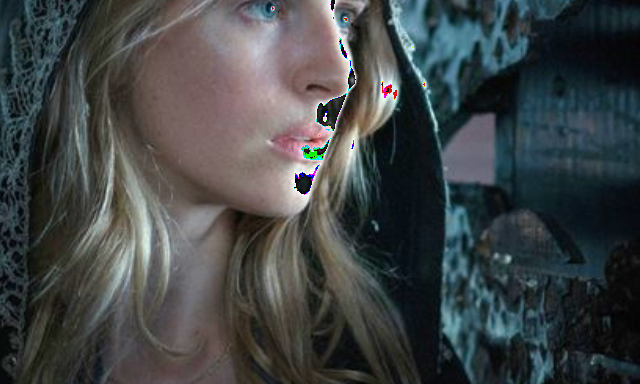

In [55]:
import torchvision

torchvision.transforms.ToPILImage()(imgs[1])